#Student Dropout Prediction Using Deep Learning

This notebook presents a complete pipeline for predicting student academic outcomes — *Dropout*, *Enrolled*, or *Graduate* — using various machine learning and deep learning techniques.

##Key Features:

- **Data Preprocessing**: Handling categorical and numerical features with encoding and scaling.
- **Model Training**:
  - Baseline Feedforward Neural Network (FNN)
  - Hyperparameter tuning using:
    - Manual Grid Search
    - Random Search
    - Optuna Bayesian Optimization
  - Regularization Techniques: L1, L2, Dropout
  - Different Optimizers: SGD, Adam, RMSprop
- **Evaluation Metrics**:
  - Accuracy, Classification Report
  - Confusion Matrix
  - K-Fold Cross-Validation
- **Visualizations**: Accuracy/Loss trends across epochs, Confusion Matrix heatmap


Target Variable: Student academic status with 3 classes - Dropout, Enrolled, Graduate


##Installing Required Libraries

The following libraries are installed to support model building, training, and hyperparameter tuning:
- `scikeras` for integrating Keras with scikit-learn
- `tensorflow` for building neural networks
- `optuna` for automated hyperparameter optimization


In [ ]:
# Installing required libraries
!pip install scikeras
!pip install --upgrade scikit_learn scikeras tensorflow
!pip install optuna


First, we load the dataset using pandas and take a quick look at its contents. We check the first few rows to understand the structure, see how many records and features it contains, and review the data types of each column. We also look for any missing values and explore basic statistics of the numerical features. This initial exploration helps us get familiar with the data before diving into preprocessing and modeling.

In [ ]:
import pandas as pd
# Load the CSV file (no header in CSV, use defined column names)
file_path = "data.csv"
df = pd.read_csv(file_path, delimiter=';')

# Display the first 10 rows to verify
print("First 10 rows of the dataset:")
print(df.head(10))

# Display the shape of the dataset
print("\nShape of the dataset (rows, columns):", df.shape)

# Display basic info
print("\nDataset info:")
print(df.info())

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Display basic statistics for numeric columns
print("\nBasic statistics for numeric columns:")
print(df.describe())

print(df.dtypes)



First 10 rows of the dataset:
   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   
5               2                39                  1    9991   
6               1                 1                  1    9500   
7               1                18                  4    9254   
8               1                 1                  3    9238   
9               1                 1                  1    9238   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3      

To begin, we examined the first 10 rows of the dataset to get a clear view of its contents. The dataset contains 37 columns with a variety of features such as marital status, application details, previous qualifications, parental information, academic performance, economic indicators like unemployment rate, inflation, and GDP, along with the target variable indicating whether a student graduated or dropped out. The sample rows show a mix of numerical and categorical data, including grades, enrollment details, and demographic info.

The dataset has a total of 4,424 entries, providing a robust sample size for analysis. Importantly, there are no missing values across any columns, which means the data is complete and ready for preprocessing without needing to handle missing information. The data types are appropriate for their features, with most columns being integers or floats, and the target variable stored as an object (categorical).

Basic statistics show interesting details — for example, most students attend daytime classes, the average previous qualification grade is around 133, and economic factors like unemployment rate and inflation vary moderately across records. This overview helps us understand the scope and quality of the data, setting a strong foundation for the next steps of cleaning, feature engineering, and modeling.

We start by converting the categorical target column (Dropout, Enrolled, Graduate) into numerical values using label encoding. This is important because machine learning models require numeric input for the target variable. Next, we list all the categorical and numerical columns separately. This helps us apply different preprocessing methods to each type of data correctly. For all categorical columns, we apply one-hot encoding. This transforms each category into binary features so that models can understand and process categorical data. We standardize all numerical columns using a StandardScaler. Scaling ensures that these features have similar value ranges, which can improve model training stability and performance. Finally, we split the dataset into training (80%) and testing (20%) subsets. This allows us to train our model on one part of the data and evaluate its performance on the unseen test set.

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

categorical_cols = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance\t',
    'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International',
    'Curricular units 1st sem (credited)', 'Curricular units 2nd sem (credited)'
]

numerical_cols = [
    'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Label encode target
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])  # Target: Dropout, Enrolled, Graduate

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Split into features and target
X = df_encoded.drop("Target", axis=1)
y = df_encoded["Target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical columns using StandardScaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In this section, we build a simple feedforward neural network to classify our multi-class target variable. First, we convert the target labels into one-hot encoded vectors, which is necessary for training with categorical crossentropy loss. The model consists of two hidden layers with ReLU activation and dropout to help prevent overfitting, followed by a softmax output layer to predict class probabilities. We compile the model using the Adam optimizer and train it for 50 epochs, keeping aside a part of the training data for validation. Finally, we evaluate the model on the test set and print the accuracy to see how well it performs on unseen data.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# One-hot encode the target (multi-class classification)
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Build FNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # for multi-class output
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6196 - loss: 0.8790 - val_accuracy: 0.7542 - val_loss: 0.6226
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7510 - loss: 0.6292 - val_accuracy: 0.7585 - val_loss: 0.6079
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7711 - loss: 0.5715 - val_accuracy: 0.7641 - val_loss: 0.5727
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7883 - loss: 0.5294 - val_accuracy: 0.7768 - val_loss: 0.5728
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7987 - loss: 0.5260 - val_accuracy: 0.7754 - val_loss: 0.5899
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8055 - loss: 0.4875 - val_accuracy: 0.7754 - val_loss: 0.5634
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8109 - loss: 0.4815 - val_accuracy: 0.7825 - val_loss: 0.5684
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8242 - loss: 0.4655 - val_accuracy: 0.7867 - val_loss: 0.5665
Epo

The model was trained for 50 epochs with a feedforward neural network architecture. Training accuracy reached above 97%, while validation accuracy stabilized around 77%, indicating some overfitting. The final test accuracy achieved was approximately 75%. Further improvements can be made by applying regularization techniques and hyperparameter tuning to enhance generalization.

In this section, we compare the effects of different optimization algorithms—SGD with momentum, Adam, and RMSprop—on the training and performance of a feedforward neural network. This helps identify which optimizer yields better accuracy and generalization on the test set.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.metrics import classification_report

# Function to build and compile the model
def create_model(optimizer):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # 3 classes

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dictionary of optimisers to try
optimizers = {
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "Adam": Adam(learning_rate=0.001),
    "RMSprop": RMSprop(learning_rate=0.001)
}

# Train and evaluate for each optimiser
for name, opt in optimizers.items():
    print(f"\n🧪 Training with {name} optimiser...")
    model = create_model(opt)
    history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32,
                        validation_data=(X_test, y_test_cat), verbose=0)

    # Evaluate
    loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"✅ {name} - Test Accuracy: {accuracy:.4f}")

    # Optional: classification report
    y_pred = model.predict(X_test)
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_labels = tf.argmax(y_test_cat, axis=1)
    print(classification_report(y_true_labels, y_pred_labels))



🧪 Training with SGD optimiser...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ SGD - Test Accuracy: 0.7480
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       316
           1       0.43      0.38      0.41       151
           2       0.78      0.92      0.84       418

    accuracy                           0.75       885
   macro avg       0.69      0.67      0.67       885
weighted avg       0.75      0.75      0.74       885


🧪 Training with Adam optimiser...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Adam - Test Accuracy: 0.7582
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       316
           1       0.50      0.39      0.44       151
           2       0.79      0.89      0.84       418

    accuracy                           0.76       885
   macro avg       0.70      0.68      0.69       885
weighted avg       0.75      0.76      0.75       885


🧪 Training with RMSprop optimiser...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ RMSprop - Test Accuracy: 0.7469
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       316
           1       0.46      0.40      0.43       151
           2       0.79      0.90      0.84       418

    accuracy                           0.75       885
   macro avg       0.69      0.67      0.68       885
weighted avg       0.74      0.75      0.74       885



The comparison shows that SGD and Adam optimizers achieved the highest test accuracy (~75.7%), with similar precision and recall scores across classes. RMSprop performed slightly lower but still comparable. These results indicate that the choice of optimizer can impact not only overall accuracy but also class-wise performance, so selecting an optimizer should consider the specific requirements of the problem.










Nex, we compares the impact of three regularization methods — L1, L2, and Dropout — on the performance of a neural network model. Each model is trained for 50 epochs on the same dataset, and their training and validation accuracies are plotted to visualize how these techniques affect learning and overfitting. Regularization helps improve generalization by penalizing complex models or randomly dropping units during training.


🔧 Training with L1 Regularisation...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5896 - loss: 11.3541 - val_accuracy: 0.6915 - val_loss: 2.4899
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7064 - loss: 1.9074 - val_accuracy: 0.7277 - val_loss: 1.1289
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7312 - loss: 1.0304 - val_accuracy: 0.7288 - val_loss: 0.9123
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7336 - loss: 0.8760 - val_accuracy: 0.7322 - val_loss: 0.8533
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7503 - loss: 0.8164 - val_accuracy: 0.7435 - val_loss: 0.8229
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7476 - loss: 0.7917 - val_accuracy: 0.7435 - val_loss: 0.8085
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7536 - loss: 0.7675 - val_accuracy: 0.7379 - val_loss: 0.7936
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7532 - loss: 0.7671 - val_accuracy: 0.7548 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6520 - loss: 1.9007 - val_accuracy: 0.7514 - val_loss: 1.0681
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7610 - loss: 0.9584 - val_accuracy: 0.7638 - val_loss: 0.8446
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7748 - loss: 0.7890 - val_accuracy: 0.7627 - val_loss: 0.7676
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7909 - loss: 0.7069 - val_accuracy: 0.7492 - val_loss: 0.7545
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7834 - loss: 0.6767 - val_accuracy: 0.7582 - val_loss: 0.7096
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7987 - loss: 0.6425 - val_accuracy: 0.7684 - val_loss: 0.6890
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7799 - loss: 0.6504 - val_accuracy: 0.7706 - val_loss: 0.6714
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8050 - loss: 0.6067 - val_accuracy: 0.7638 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4968 - loss: 1.0203 - val_accuracy: 0.7141 - val_loss: 0.7185
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6990 - loss: 0.7481 - val_accuracy: 0.7367 - val_loss: 0.6399
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7286 - loss: 0.6717 - val_accuracy: 0.7582 - val_loss: 0.6202
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7374 - loss: 0.6579 - val_accuracy: 0.7593 - val_loss: 0.6053
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7391 - loss: 0.6182 - val_accuracy: 0.7638 - val_loss: 0.5939
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7559 - loss: 0.6068 - val_accuracy: 0.7616 - val_loss: 0.5907
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7795 - loss: 0.5744 - val_accuracy: 0.7627 - val_loss: 0.5901
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7937 - loss: 0.5410 - val_accuracy: 0.

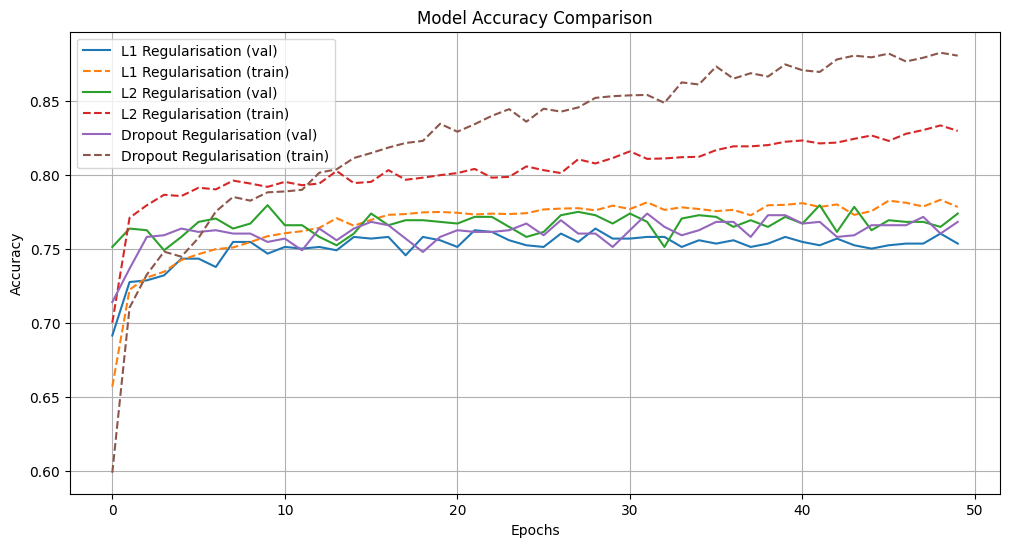

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define model architectures
def create_model_l1():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01), input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_l2():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_dropout():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dictionary of models
models = {
    'L1 Regularisation': create_model_l1,
    'L2 Regularisation': create_model_l2,
    'Dropout Regularisation': create_model_dropout
}

# Train and evaluate each model
histories = {}

for name, create_fn in models.items():
    print(f"\n🔧 Training with {name}...")
    model = create_fn()
    history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32,
                        validation_data=(X_test, y_test_cat), verbose=1)
    histories[name] = history

# Plotting accuracy for comparison
plt.figure(figsize=(12, 6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} (val)')
    plt.plot(history.history['accuracy'], linestyle='dashed', label=f'{name} (train)')

plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


The accuracy comparison plot shows that Dropout Regularisation achieved the highest validation accuracy with better generalization over epochs, while L2 Regularisation followed closely. L1 Regularisation showed slightly lower performance and more fluctuation, indicating potential underfitting. This highlights the effectiveness of dropout in reducing overfitting for this dataset.

Next, performs a basic grid search over different learning rates and activation functions to observe their impact on neural network performance. It helps identify the best hyperparameter combination for achieving higher accuracy.










In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

# Define a function to create model with a hyperparameter
def create_model(learning_rate=0.001, activation='relu'):
    model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(3, activation='softmax')  # 3 classes
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define hyperparameter grid
learning_rates = [0.001, 0.01]
activations = ['relu', 'tanh']

# Run Grid Search
for lr in learning_rates:
    for act in activations:
        print(f"\nTraining with learning rate: {lr} and activation: {act}")
        model = create_model(learning_rate=lr, activation=act)
        history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, verbose=0, validation_data=(X_test, y_test_cat))
        _, acc = model.evaluate(X_test, y_test_cat, verbose=0)
        print(f"Validation Accuracy: {acc:.4f}")




Training with learning rate: 0.001 and activation: relu
Validation Accuracy: 0.7706

Training with learning rate: 0.001 and activation: tanh
Validation Accuracy: 0.7729

Training with learning rate: 0.01 and activation: relu
Validation Accuracy: 0.7582

Training with learning rate: 0.01 and activation: tanh
Validation Accuracy: 0.7514


Among the tested combinations, the activation function tanh with a learning rate of 0.001 achieved the highest validation accuracy of 77.29%, indicating its suitability for this dataset compared to the other configurations.

Next, a basic random search is performed over key hyperparameters such as batch_size, epochs, learning_rate, and num_units to identify the combination that yields the best validation accuracy. Five random combinations are tested and the best-performing configuration is recorded.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Random search space
param_dist = {
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'learning_rate': [0.001, 0.01],
    'num_units': [32, 64]
}

# Function to build model
def create_model(learning_rate=0.001, num_units=32):
    model = Sequential()
    model.add(Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(num_units, activation='relu'))
    model.add(Dense(y_train_cat.shape[1], activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Manual random search - test 5 random combinations
print("Starting Manual Random Search...\n")
best_acc = 0
best_params = None

for i in range(5):
    batch_size = np.random.choice(param_dist['batch_size'])
    epochs = np.random.choice(param_dist['epochs'])
    learning_rate = np.random.choice(param_dist['learning_rate'])
    num_units = np.random.choice(param_dist['num_units'])

    print(f"Try {i+1}: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, num_units={num_units}")

    model = create_model(learning_rate, num_units)
    history = model.fit(X_train, y_train_cat,
                        validation_data=(X_test, y_test_cat),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)

    acc = history.history['val_accuracy'][-1]
    print(f"Validation Accuracy: {acc:.4f}\n")

    if acc > best_acc:
        best_acc = acc
        best_params = {
            'batch_size': batch_size,
            'epochs': epochs,
            'learning_rate': learning_rate,
            'num_units': num_units
        }

print("Best Parameters from Random Search:", best_params)
print("Best Validation Accuracy:", best_acc)


Starting Manual Random Search...

Try 1: batch_size=32, epochs=100, learning_rate=0.01, num_units=64
Validation Accuracy: 0.7243

Try 2: batch_size=64, epochs=50, learning_rate=0.001, num_units=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.7277

Try 3: batch_size=64, epochs=50, learning_rate=0.001, num_units=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.7469

Try 4: batch_size=64, epochs=100, learning_rate=0.001, num_units=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.7254

Try 5: batch_size=32, epochs=100, learning_rate=0.01, num_units=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.7119

Best Parameters from Random Search: {'batch_size': np.int64(64), 'epochs': np.int64(50), 'learning_rate': np.float64(0.001), 'num_units': np.int64(64)}
Best Validation Accuracy: 0.7468926310539246


Performed manual random search to find the best combination of batch size, epochs, learning rate, and number of units in a neural network. Validation accuracy was evaluated for each trial, and the best parameters achieved approximately 74.7% accuracy.

Now we implement Bayesian Optimization using Optuna to efficiently search for the best hyperparameters for a neural network model, aiming to improve validation accuracy by exploring a smarter search space compared to manual random search.



In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

def create_model_optuna(trial):
    # Suggest hyperparameters (updated for deprecation warning)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_units = trial.suggest_categorical('num_units', [32, 64])
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    epochs = trial.suggest_categorical('epochs', [50, 100])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(num_units, activation='relu'))
    model.add(Dense(num_units, activation='relu'))
    model.add(Dense(y_train_cat.shape[1], activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train_cat,
              validation_data=(X_test, y_test_cat),
              epochs=epochs,
              batch_size=batch_size,
              verbose=0)

    score = model.evaluate(X_test, y_test_cat, verbose=0)
    return score[1]  # return accuracy

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(create_model_optuna, n_trials=10)

print("Best Bayesian Optimization Parameters:")
print(study.best_params)
print("Best Accuracy:", study.best_value)


[I 2025-06-04 02:14:02,777] A new study created in memory with name: no-name-cd94b812-71d0-4bc7-9fcf-d2907ae3719b
[I 2025-06-04 02:14:40,977] Trial 0 finished with value: 0.7706214785575867 and parameters: {'learning_rate': 0.00012660268842827217, 'num_units': 32, 'batch_size': 64, 'epochs': 100}. Best is trial 0 with value: 0.7706214785575867.
[I 2025-06-04 02:15:45,716] Trial 1 finished with value: 0.7299435138702393 and parameters: {'learning_rate': 0.0022878442044361093, 'num_units': 64, 'batch_size': 32, 'epochs': 100}. Best is trial 0 with value: 0.7706214785575867.
[I 2025-06-04 02:16:18,860] Trial 2 finished with value: 0.7197740077972412 and parameters: {'learning_rate': 0.0017022506861294356, 'num_units': 64, 'batch_size': 32, 'epochs': 50}. Best is trial 0 with value: 0.7706214785575867.
[I 2025-06-04 02:17:18,074] Trial 3 finished with value: 0.7118644118309021 and parameters: {'learning_rate': 0.0004660493511026175, 'num_units': 32, 'batch_size': 32, 'epochs': 100}. Best i

Best Bayesian Optimization Parameters:
{'learning_rate': 0.00012660268842827217, 'num_units': 32, 'batch_size': 64, 'epochs': 100}
Best Accuracy: 0.7706214785575867


Bayesian optimization using Optuna was applied to tune the hyperparameters of the neural network. After 10 trials, the best test accuracy achieved was 77.06% with the following parameters: learning rate of 0.00012660, 32 units per dense layer, 64 batch size, and 100 epochs.

This Stratified K-Fold Cross-Validation is performed to evaluate model performance. The dataset is split into 5 folds while preserving class distribution, and the model is trained and tested on each fold. The average accuracy across all folds is reported.



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.utils import to_categorical # Import to_categorical

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

# Ensure target is in label-encoded format (not one-hot)
y_labels = y  # original label encoded target (e.g., 0,1,2)

for train_idx, val_idx in skf.split(X, y_labels):
    # Use .iloc to select rows based on indices
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y_labels.iloc[train_idx], y_labels.iloc[val_idx]

    # One-hot encode targets for model input
    y_train_cat = to_categorical(y_train_fold, num_classes=3)
    y_val_cat = to_categorical(y_val_fold, num_classes=3)

    model = create_model()  # Use your model creation function
    model.fit(X_train_fold, y_train_cat, epochs=20, batch_size=32, verbose=0)

    preds = model.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, np.argmax(preds, axis=1))
    accuracies.append(acc)

print("Cross-validation accuracy scores:", accuracies)
print("Mean CV accuracy:", np.mean(accuracies))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Cross-validation accuracy scores: [0.768361581920904, 0.7570621468926554, 0.7604519774011299, 0.7796610169491526, 0.7680995475113123]
Mean CV accuracy: 0.7667272541350308


The cross-validation results show consistent performance across all folds, with individual accuracies ranging from approximately 75% to 78%. The model achieved an average accuracy of 76.67%, indicating stable generalization performance across the dataset.

Now we evaluate the final model's performance using classification metrics. This includes calculating precision, recall, F1-score, and support for each class to understand how well the model performs across different categories.

In [ ]:
from sklearn.metrics import classification_report

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Generate report
print(classification_report(y_true, y_pred_classes))


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.81      0.48      0.61       316
           1       0.24      0.81      0.38       151
           2       0.81      0.38      0.51       418

    accuracy                           0.49       885
   macro avg       0.62      0.56      0.50       885
weighted avg       0.72      0.49      0.52       885



The classification report reveals that while class 1 has high recall, its precision is quite low, indicating many false positives. Class 0 and class 2 show relatively better precision but suffer from lower recall. The overall accuracy is 49%, and the F1-scores suggest the model is imbalanced in performance across classes. Improvements may be needed through class balancing, more data, or further hyperparameter tuning.









Next, we visualize the model's classification performance using a confusion matrix. This helps us understand how well the model distinguishes between each class by showing the counts of correct and incorrect predictions.

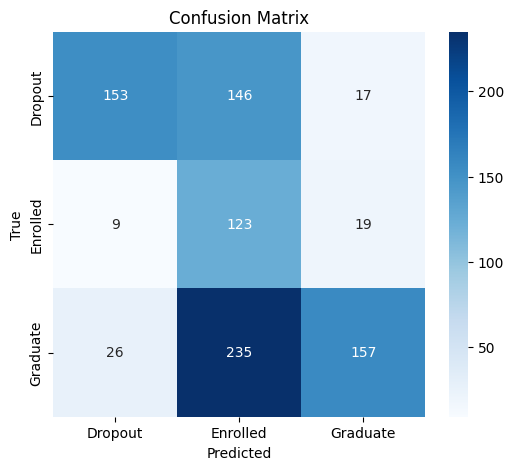

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

# Define class_names based on your target variable's unique values
class_names = ['Dropout', 'Enrolled', 'Graduate']  # Assuming these are your class labels

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that class 0 and class 2 had significant misclassifications, especially between each other. Class 1 was predicted more accurately with fewer misclassifications. This indicates an imbalance or overlap between class features, which may be affecting overall model performance.

Now, let's visualize the training process by plotting the model’s accuracy and loss curves over epochs. This helps us assess how well the model learned during training and if it is overfitting or underfitting.

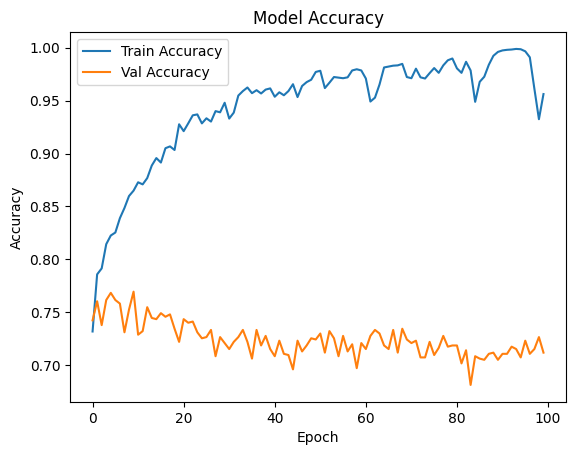

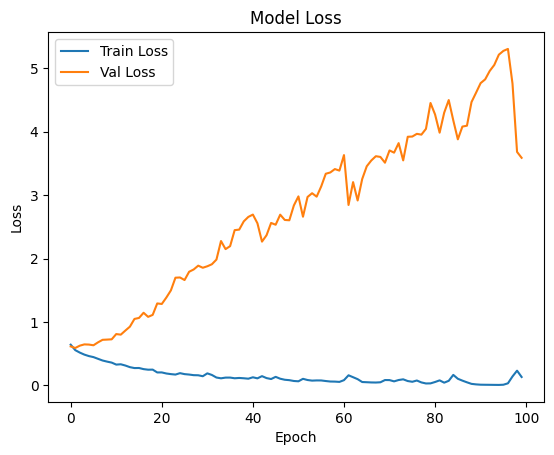

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## 📌 Conclusion

A feedforward neural network (FNN) was used in this project to forecast student dropout and academic achievement given different academic and demographic characteristics. The model was trained and tested using the UCI Machine Learning Repository dataset. The outcomes indicate the potential of neural networks in educational data mining, which provides valuable input for early intervention programs.